In [1]:
import sys
from itertools import product
# for calculating perfromance 
from sklearn.metrics import mean_absolute_error, median_absolute_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# variables
project_name = "RF+Clust"
project_folder = f"C:/Users/anani/Downloads/{project_name}"
sys.path.append(project_folder)

from variables import suite_name, features, target, transformation, budgets, algorithms
from variables import n_folds, crossval_column
from variables import model_name
from variables import metric, calibration_method, similarity_thresholds, weights_method
from utils import read_fold_data

In [3]:
suite_name = "bbob"

In [4]:
def mae(df, col_name):
    """
    Function to calculate MAE.
    """
    mae = mean_absolute_error(df['true'].values, df['predicted'].values)

    return pd.Series({col_name: mae})

In [5]:
def mdae(df, col_name):
    """
    Function to calculate MDAE.
    """
    mdae = median_absolute_error(df['true'].values, df['predicted'].values)

    return pd.Series({col_name: mdae})

In [6]:
def boxplot(df, figsize, font_scale, save, title, save_path, **kwargs):
    """
    Function to plot and save a costumized boxplot.
    """
    # set up figure
    sns.set()
    sns.set_theme(style='white', font_scale=font_scale)
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    # plot
    g = sns.boxplot(data=df, **kwargs)
    
    # enhance plot    
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.1, title=kwargs["hue"])
    plt.tight_layout()

    # save
    if save:
        plt.savefig(f'{save_path}/{title}.png', bbox_inches='tight', dpi=300)
    
    plt.show()
    plt.close

In [7]:
# Data in 2D TODO: 

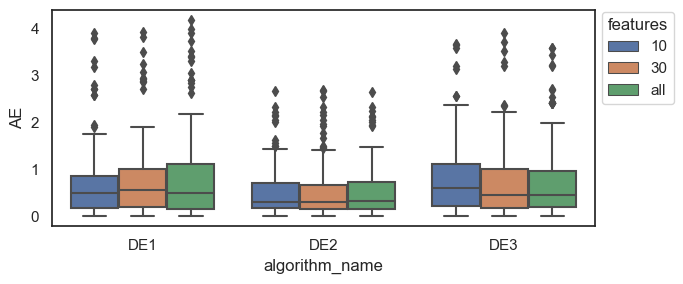

\begin{tabular}{lrrr}
\toprule
{} & \multicolumn{3}{l}{value} \\
algorithm\_name &       DE1 &       DE2 &       DE3 \\
variable &       mae &       mae &       mae \\
features &           &           &           \\
\midrule
10       &  0.716409 &  0.544865 &  0.790158 \\
30       &  0.758639 &  0.573644 &  0.737953 \\
all      &  0.845840 &  0.551419 &  0.784079 \\
\bottomrule
\end{tabular}



C:\Users\anani\AppData\Local\Temp\ipykernel_9600\2911869702.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(performance.pivot(columns=["algorithm_name", "variable"], index="features").to_latex())


In [8]:
# RF performance on the algorithms for different number of features
rf_predictions = pd.DataFrame()
performance = pd.DataFrame()

for algorithm_name, budget in product(algorithms, budgets):
    for features in [10, 30, "all"]:
        
        results_folder = f"{project_folder}/Results/{suite_name}/transformation={transformation}_features={features}/{model_name}"
        results_folder_temp = f"{results_folder}/algorithm_name={algorithm_name}_budget={budget}"

        predictions_temp = pd.read_csv(f"{results_folder_temp}/predictions/predictions_set=test.csv")
        predictions_temp["algorithm_name"] = algorithm_name
        predictions_temp["features"] = features
        predictions_temp["model"] = "RF"
        
        rf_predictions = pd.concat([rf_predictions, predictions_temp], axis=0)

# plot
predictions_plot = rf_predictions.copy()
predictions_plot["AE"] = abs(rf_predictions["true"] - rf_predictions["predicted"])
                             
boxplot(df=predictions_plot, figsize=(7, 3), font_scale=1, save=True, title="RF_performance_boxplot"
        , save_path=f"{project_folder}/Results/{suite_name}"
        , x="algorithm_name", y="AE", hue="features")
       
# calculate MAE and MDAE
performance["mae"] = rf_predictions.groupby(["algorithm_name", "features"]).apply(mae, ("mae"))
# performance["mdae"] = rf_predictions.groupby(["algorithm_name", "features"]).apply(mdae, ("mdae"))
performance = performance.reset_index()
performance = performance.melt(id_vars=["algorithm_name", "features"])
print(performance.pivot(columns=["algorithm_name", "variable"], index="features").to_latex())

# Performance Summary

### mean/median

In [9]:
rf_predictions.copy()

,f_id,i_id,true,predicted,algorithm_name,features,model
0,1,1,0.004468,0.563044,DE1,10,RF
1,1,2,0.001517,0.563044,DE1,10,RF
2,1,3,0.002879,0.563044,DE1,10,RF
3,1,4,0.002733,0.597717,DE1,10,RF
4,1,5,0.003954,0.563044,DE1,10,RF
...,...,...,...,...,...,...,...
115,24,1,1.717523,0.678497,DE3,all,RF
116,24,2,1.692746,0.688733,DE3,all,RF
117,24,3,1.721075,0.678497,DE3,all,RF
118,24,4,1.722035,0.711934,DE3,all,RF


In [10]:
# create results placeholder
rfclust_predictions = rf_predictions.copy()

for algorithm_name, budget in product(algorithms, budgets):
#     print(f"algorithm_name: {algorithm_name}")

    for features in [10, 30, "all"]:
#         print(f"features: {features}")
        
        # define directories
        results_folder = f"{project_folder}/Results/{suite_name}/transformation={transformation}_features={features}/{model_name}"
        results_folder_temp = f"{results_folder}/algorithm_name={algorithm_name}_budget={budget}"

        for similarity_threshold in similarity_thresholds: 
#             print(f"similarity_threshold: {similarity_threshold}")
            
            title = f"predictions_metric={metric}_threshold={similarity_threshold}_method={calibration_method}_weights={weights_method}"
            predictions = pd.read_csv(f"{results_folder_temp}/rfclust/{title}.csv")
            
            predictions["features"] = features
            predictions["model"] = similarity_threshold
            predictions["algorithm_name"] = algorithm_name
            
            rfclust_predictions = pd.concat([rfclust_predictions, predictions], axis=0)

# calculate mae
performance = pd.DataFrame() 
performance = rfclust_predictions.groupby(["algorithm_name", "model", "features"]).apply(mae, ("mae")).reset_index()

# select for features = 10
# print("Peformance features=10: ")
performance = performance[performance["features"] == 10]
performance = performance.drop("features", axis=1)
print(performance.pivot(columns="algorithm_name", index=["model"]).reindex(["RF", 0.9, 0.7, 0.5]).to_latex())

\begin{tabular}{lrrr}
\toprule
{} & \multicolumn{3}{l}{mae} \\
algorithm\_name &       DE1 &       DE2 &       DE3 \\
model &           &           &           \\
\midrule
RF    &  0.716409 &  0.544865 &  0.790158 \\
0.9   &  0.771134 &  0.581848 &  0.824243 \\
0.7   &  0.735131 &  0.582422 &  0.771385 \\
0.5   &  0.713628 &  0.578257 &  0.748825 \\
\bottomrule
\end{tabular}



C:\Users\anani\AppData\Local\Temp\ipykernel_9600\3902566795.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(performance.pivot(columns="algorithm_name", index=["model"]).reindex(["RF", 0.9, 0.7, 0.5]).to_latex())


### counts

In [11]:
# create results placeholder
compare_models = pd.DataFrame()

for algorithm_name, budget in product(algorithms, budgets):
#     print(f"algorithm_name: {algorithm_name}")

    for features in [10, 30, "all"]:
#         print(f"features: {features}")

        # define directories
        results_folder = f"{project_folder}/Results/{suite_name}/transformation={transformation}_features={features}/{model_name}"
        results_folder_temp = f"{results_folder}/algorithm_name={algorithm_name}_budget={budget}"

        # read AE
        ae = pd.read_csv(f"{results_folder_temp}/rfclust/ae_compare_models_features={features}.csv", index_col="model")
    
        # count how many times RF+Clust was beter, worse or equal to RF
        compare_models_temp = pd.DataFrame()

        for idx in [idx for idx in ae.index if idx != 'RF']:
            compare_models_temp.loc[idx, 'times_better'] = int(sum(np.where(ae.loc['RF', :]
                                                                     > ae.loc[idx, :], 1, 0)))    
            compare_models_temp.loc[idx, 'times_equal'] = int(sum(np.where(ae.loc['RF', :]
                                                                     == ae.loc[idx, :], 1, 0)))
            compare_models_temp.loc[idx, 'times_worse'] = int(sum(np.where(ae.loc['RF', :]
                                                                     < ae.loc[idx, :], 1, 0)))
        
        compare_models_temp["features"] = features       
        compare_models_temp["algorithm_name"] = algorithm_name        
        compare_models = pd.concat([compare_models, compare_models_temp], axis=0)

# select for features = 10
# print("Peformance features=10: ")
compare_models = compare_models[compare_models["features"] == 10]
compare_models = compare_models.drop("features", axis=1)

print(compare_models.to_latex())

\begin{tabular}{lrrrl}
\toprule
{} &  times\_better &  times\_equal &  times\_worse & algorithm\_name \\
\midrule
0.9 &          37.0 &         29.0 &         54.0 &            DE1 \\
0.7 &          52.0 &          4.0 &         64.0 &            DE1 \\
0.5 &          59.0 &          0.0 &         61.0 &            DE1 \\
0.9 &          31.0 &         31.0 &         58.0 &            DE2 \\
0.7 &          56.0 &          2.0 &         62.0 &            DE2 \\
0.5 &          55.0 &          0.0 &         65.0 &            DE2 \\
0.9 &          45.0 &         31.0 &         44.0 &            DE3 \\
0.7 &          71.0 &          0.0 &         49.0 &            DE3 \\
0.5 &          77.0 &          0.0 &         43.0 &            DE3 \\
\bottomrule
\end{tabular}



C:\Users\anani\AppData\Local\Temp\ipykernel_9600\3119448697.py:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(compare_models.to_latex())
